# Notebook summary : Run_GLM_model

This notebook optimizies and Runs the GLM logistic regression model that is the core of SMS. It uses statsmodels to do this. 

In the section 1, we transform some of the phenotypes to make it easily run on the model 

In the section 2, we run the model and assess it's accuracy via puesdo r^2

In section 3, we assess the models predictive power (by PRC) 



import functions
--

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
import ast

import statsmodels
from sklearn.metrics import auc
import SMS
from SMS.GLM import *
from importlib import reload

from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
import statsmodels.api as sm



import/load data
--

In [23]:
data_directory='/Users/hannahjacobs/Dropbox (MIT)/GradSchool/Finucane/SMS_project/data/for_mode_fitting/'



variants_affecting_phenotypes_within_5kb_verfied_ss=pd.read_csv(data_directory+'sQTLs_for_model_fit.csv.gz', compression='gzip', 
                                                    low_memory=False)







In [24]:
def get_prc(model_outputs, prc,thresholds):
    
    thresholds = list(prc.threshold)

    model_outputs['binned_threshold'] = pd.cut(model_outputs['predicted_prob_being_causal'], thresholds)

    prc['binned_threshold'] = pd.cut(prc['threshold'], thresholds)

    model_outputs=model_outputs.merge(prc, on='binned_threshold')

    return model_outputs



about ~5% are not in introns or exons: likely because the variants are outside the first and last exons. for now I am excluding these.


In [4]:
variants_affecting_phenotypes_within_5kb=variants_affecting_phenotypes_within_5kb[~variants_affecting_phenotypes_within_5kb.annot_info.isna()]

region=variants_affecting_phenotypes_within_5kb.annot_info.apply(lambda x: x.split('_')[1])

variants_affecting_phenotypes_within_5kb=variants_affecting_phenotypes_within_5kb.assign(region=region)

both_splice_regions = (variants_affecting_phenotypes_within_5kb.in_splice_region_leafcutter==1) & (variants_affecting_phenotypes_within_5kb.in_ss_gencode==1)

just_leafcutter_ss = (variants_affecting_phenotypes_within_5kb.in_splice_region_leafcutter==1) & (variants_affecting_phenotypes_within_5kb.in_ss_gencode==0)

just_gencode_ss = (variants_affecting_phenotypes_within_5kb.in_splice_region_leafcutter==0) & (variants_affecting_phenotypes_within_5kb.in_ss_gencode==1)

variants_affecting_phenotypes_within_5kb=variants_affecting_phenotypes_within_5kb.assign(both_splice_regions=both_splice_regions)
variants_affecting_phenotypes_within_5kb=variants_affecting_phenotypes_within_5kb.assign(just_leafcutter_ss=just_leafcutter_ss)
variants_affecting_phenotypes_within_5kb=variants_affecting_phenotypes_within_5kb.assign(just_gencode_ss=just_gencode_ss)


#seperate out if in intron or exon, then into the three classes of SS


in_any_intron=(variants_affecting_phenotypes_within_5kb.abs_min_dis_to_splice_site_within_cluster!=0) & (variants_affecting_phenotypes_within_5kb.region=='intron')

variants_affecting_phenotypes_within_5kb=variants_affecting_phenotypes_within_5kb.assign(in_any_intron=in_any_intron)


in_any_exon=(variants_affecting_phenotypes_within_5kb.abs_min_dis_to_splice_site_within_cluster!=0) & (variants_affecting_phenotypes_within_5kb.region=='exon')

variants_affecting_phenotypes_within_5kb=variants_affecting_phenotypes_within_5kb.assign(in_any_exon=in_any_exon)

introns=variants_affecting_phenotypes_within_5kb[~variants_affecting_phenotypes_within_5kb.in_any_exon]

exons=variants_affecting_phenotypes_within_5kb[variants_affecting_phenotypes_within_5kb.in_any_exon]



variants_affecting_phenotypes_within_5kb.loc[variants_affecting_phenotypes_within_5kb.just_gencode_ss==True, 'region'] = 'just_gencode_ss'
variants_affecting_phenotypes_within_5kb.loc[variants_affecting_phenotypes_within_5kb.both_splice_regions==True, 'region'] = 'both_splice_regions'
variants_affecting_phenotypes_within_5kb.loc[variants_affecting_phenotypes_within_5kb.just_leafcutter_ss==True, 'region'] = 'just_leafcutter_ss'


In [5]:
variants_affecting_phenotypes_within_5kb['distance_bin_gtex']=pd.cut(variants_affecting_phenotypes_within_5kb.abs_min_dist_to_a_ss_gtex, [-1, 30, 300, 3000, 5001])
with open(data_directory+'list_of_ss_to_exclude.txt', 'r') as f:

    lines = f.readlines()

list_of_ss_to_exclude=[l.split('\n')[0] for l in lines]
variants_affecting_phenotypes_within_5kb_verfied_ss=variants_affecting_phenotypes_within_5kb[~variants_affecting_phenotypes_within_5kb.ID.isin(list_of_ss_to_exclude)]


# Run + asssess GLM model

A logistic regression model is a generalized linear model that attempts to predict the binary outcome based on a set of features. Shown below is an example for a model with one feature:



The following syntax is used for the models:

for a given *name of model*:

- model_fit_*name* : the GLM output

- train_df_*name* : the training df used in the model

- test_df_*name* : the test set 

- model_output_*name* : the model assessed across all variants (test+train+all other PIPs)

The names of the models correspond to the following:

- full: full SMS model 
- region: only using gene annotation info (intron, exon, splice sites)
- no_dists : full model without any distance
- gtex_dist: only using gtex_distances
- gtex_dist: only using gencode_distances
- full_but_gencode_dist: full model, but using gencode distance instead of GTEx distances



run model then assess R^2, PRC
--

In [25]:
[model_fit_full, train_df_full, test_df_full, model_output_full]=SMS.GLM.run_model(variants_affecting_phenotypes_within_5kb_verfied_ss, 0.9, 0.002, 'default_features', 'w_gtex_distances')



In [27]:


puesdo_r_sq_full_model=SMS.GLM.print_puesdo_r(model_fit_full.llf, SMS.GLM.null_model_given_training_set(train_df_full).llf, False, ' of full model')



the puesdo_r_sq is 0.49173509680617533 of full model


/Users/hannahjacobs/anaconda3/envs/python38env/lib/python3.8/site-packages/pandas/core/dtypes/common.py:1691: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)


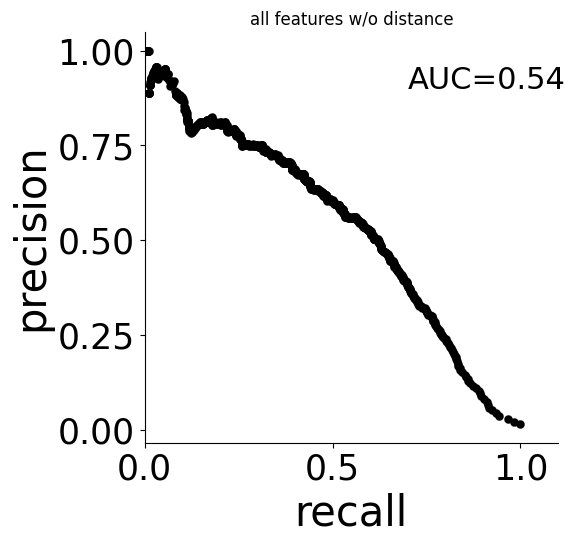

In [28]:

fig, axes = plt.subplots(1, 1, figsize=(8/1.5, 8/1.5), sharey=True)

prc=SMS.GLM.run_prc_over_thresholds(test_df_full, test_df_full.is_causal, test_df_full.predicted_prob_being_causal)
auc_precision_recall = auc(prc.recall, prc.precision)

AUC='AUC='+str(round(auc_precision_recall,2))
axes.text(0.7, 0.9, AUC, fontsize = 22)
axes.set_xlabel('recall', size=30)
axes.set_ylabel('precision', size=30)
ax=sns.scatterplot(ax=axes,data=prc, x='recall', y='precision', color='black', linewidth=0.1, edgecolor='black')
axes.tick_params(axis='x', labelsize=25 )
axes.tick_params(axis='y', labelsize=25 )
axes.set_xlim([0,1.1])
axes.set_title('all features w/o distance')


sns.despine()


other models
--

In [29]:


[model_fit_region, train_df_region, test_df_region, model_output_region]=SMS.GLM.run_model(variants_affecting_phenotypes_within_5kb_verfied_ss, 0.9, 0.002, 'annot_only', 'w_gtex_distances')



[model_fit_no_dists, train_df_no_dists, test_df_no_dists, model_output_no_dists]=SMS.GLM.run_model(variants_affecting_phenotypes_within_5kb_verfied_ss, 0.9, 0.002, 'default_features', 'no_distance')



[model_fit_gtex_dist, train_df_gtex_dist, test_df_gtex_dist, model_output_gtex_dist]=SMS.GLM.run_model(variants_affecting_phenotypes_within_5kb_verfied_ss, 0.9, 0.002, 'distance_only','w_gtex_distances' )
                                          




       





[model_fit_full_but_gencode_dist, train_df_full_but_gencode_dist, test_df_full_but_gencode_dist, model_output_full_but_gencode_dist]=SMS.GLM.run_model(variants_affecting_phenotypes_within_5kb_verfied_ss, 0.9, 0.002, 'default_features', 'w_gencode_distances')

[model_fit_gencode_dist, train_df_gencode_dist, test_df_gencode_dist, model_output_gencode_dist]=SMS.GLM.run_model(variants_affecting_phenotypes_within_5kb_verfied_ss, 0.9, 0.002, 'distance_only', 'w_gencode_distances')


plot outputs - compare sub models
--

/Users/hannahjacobs/anaconda3/envs/python38env/lib/python3.8/site-packages/pandas/core/dtypes/common.py:1691: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/Users/hannahjacobs/anaconda3/envs/python38env/lib/python3.8/site-packages/pandas/core/dtypes/common.py:1691: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/Users/hannahjacobs/anaconda3/envs/python38env/lib/python3.8/site-packages/pandas/core/dtypes/common.py:1691: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)


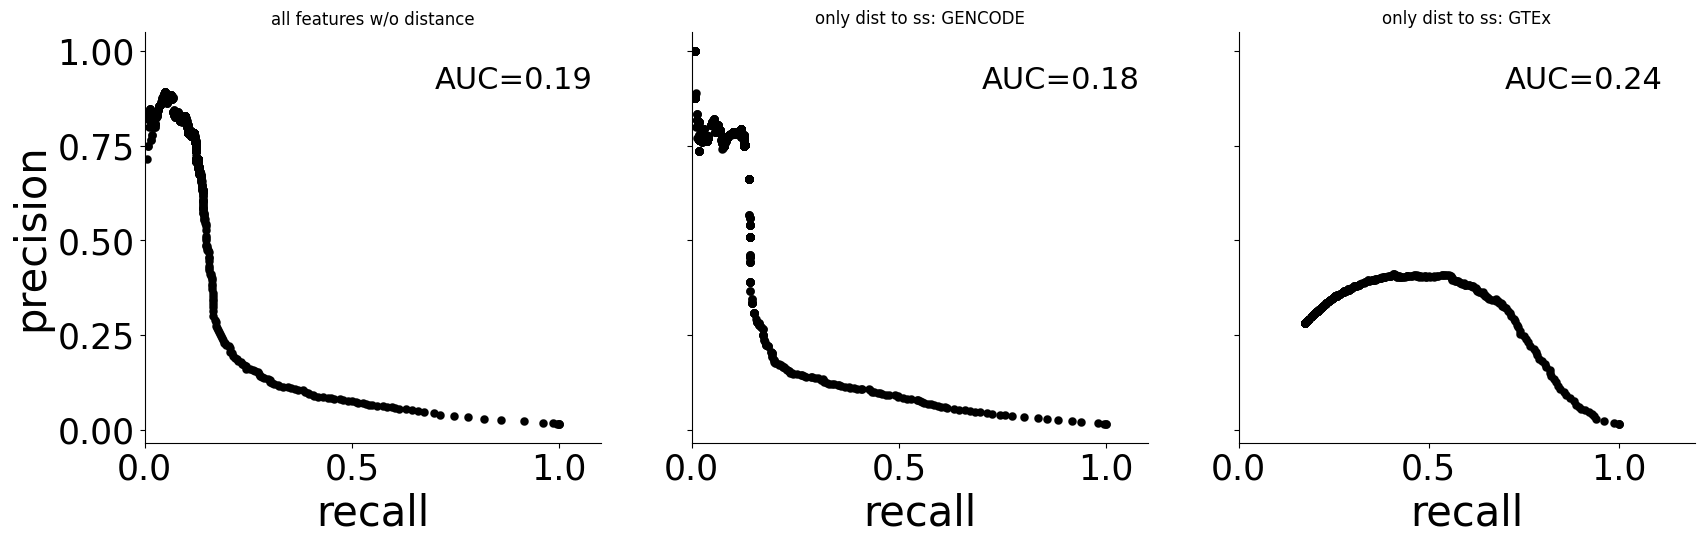

In [30]:

fig, axes = plt.subplots(1, 3, figsize=(30/1.5, 8/1.5), sharey=True)

prc=SMS.GLM.run_prc_over_thresholds(test_df_no_dists, test_df_no_dists.is_causal, test_df_no_dists.predicted_prob_being_causal)
auc_precision_recall = auc(prc.recall, prc.precision)

AUC='AUC='+str(round(auc_precision_recall,2))
axes[0].text(0.7, 0.9, AUC, fontsize = 22)
axes[0].set_xlabel('recall', size=30)
axes[0].set_ylabel('precision', size=30)
ax=sns.scatterplot(ax=axes[0],data=prc, x='recall', y='precision', color='black', linewidth=0.1, edgecolor='black')
axes[0].tick_params(axis='x', labelsize=25 )
axes[0].tick_params(axis='y', labelsize=25 )
axes[0].set_xlim([0,1.1])
axes[0].set_title('all features w/o distance')

prc=SMS.GLM.run_prc_over_thresholds(test_df_gencode_dist, test_df_gencode_dist.is_causal, test_df_gencode_dist.predicted_prob_being_causal)
ax=sns.scatterplot(ax=axes[1],data=prc, x='recall', y='precision', color='black',linewidth=0.1, edgecolor='black')
ax.set_xlabel('recall', size=30)
axes[1].tick_params(axis='x', labelsize=25 )
auc_precision_recall = auc(prc.recall, prc.precision)
AUC='AUC='+str(round(auc_precision_recall,2))
axes[1].text(0.7, 0.9, AUC, fontsize = 22)
axes[1].set_title('only dist to ss: GENCODE')
axes[1].set_xlim([0,1.1])

prc=SMS.GLM.run_prc_over_thresholds(test_df_gtex_dist, test_df_gtex_dist.is_causal, test_df_gtex_dist.predicted_prob_being_causal)
auc_precision_recall = auc(prc.recall, prc.precision)
AUC='AUC='+str(round(auc_precision_recall,2))
axes[2].text(0.7, 0.9, AUC, fontsize = 22)
axes[2].set_xlim([0,1.2])
ax=sns.scatterplot(ax=axes[2],data=prc, x='recall', y='precision', color='black', linewidth=0.1, edgecolor='black')
axes[2].set_xlabel('recall', size=30)
axes[2].tick_params(axis='x', labelsize=25 )
axes[2].set_title('only dist to ss: GTEx')


sns.despine()


In [32]:
mako_pal=sns.color_palette('mako')

/Users/hannahjacobs/anaconda3/envs/python38env/lib/python3.8/site-packages/pandas/core/dtypes/common.py:1691: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/Users/hannahjacobs/anaconda3/envs/python38env/lib/python3.8/site-packages/pandas/core/dtypes/common.py:1691: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)


NameError: name 'test_df_spliceAI' is not defined

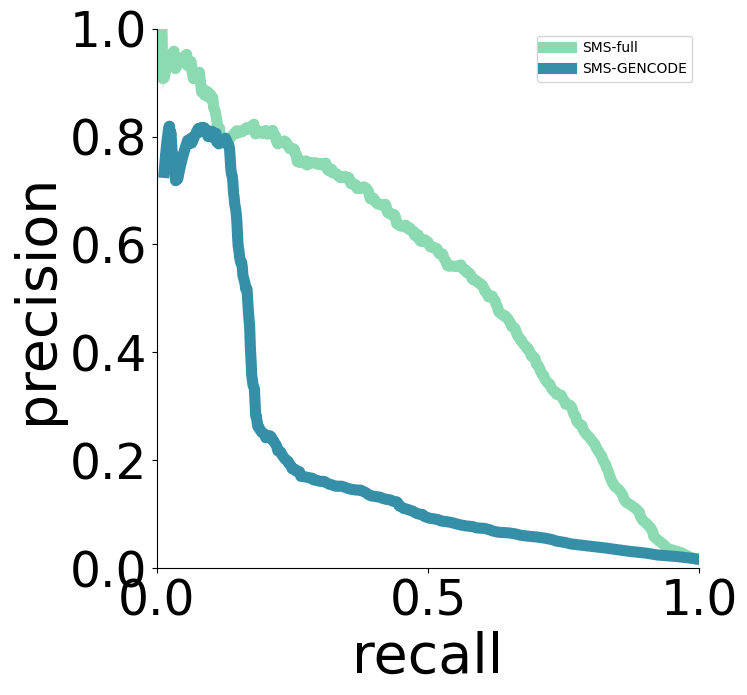

In [33]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)



r_squared='McFaddens Puesdo R^2='+str(round(puesdo_r_sq_full_model,2))

prc=SMS.GLM.run_prc_over_thresholds(test_df_full, test_df_full.is_causal, test_df_full.predicted_prob_being_causal)
auc_precision_recall = auc(prc.recall, prc.precision)

AUC='PRC AUC='+str(round(auc_precision_recall,2))
#axes.text(0, 1.1, AUC, fontsize = 22)
axes.set_xlabel('recall', size=40)
axes.set_ylabel('precision', size=40)

ax=sns.lineplot(ax=axes,data=prc, x='recall', y='precision', color=mako_pal[-1],label='SMS-full', linewidth=8, alpha=1) 
axes.tick_params(axis='y', labelsize=35 )
axes.tick_params(axis='x', labelsize=35 )
r_squared='McFaddens Puesdo R^2='+str(round(puesdo_r_sq_full_model,2))
#axes.text(1, 1.1, r_squared, fontsize = 22)

axes.set_ylim([0,1])
axes.set_xlim([0,1])
#gencode full model
prc=SMS.GLM.run_prc_over_thresholds(test_df_full_but_gencode_dist, test_df_full_but_gencode_dist.is_causal, test_df_full_but_gencode_dist.predicted_prob_being_causal)
auc_precision_recall = auc(prc.recall, prc.precision)

AUC='PRC AUC='+str(round(auc_precision_recall,2))
#axes.text(0, 1.5, AUC, fontsize = 22)


ax=sns.lineplot(ax=axes,data=prc, x='recall', y='precision', color=mako_pal[3], linewidth=8, alpha=1, label='SMS-GENCODE') 

r_squared='McFaddens Puesdo R^2='+str(round(puesdo_r_sq_full_model,2))


#splice AI model
prc=SMS.GLM.run_prc_over_thresholds(test_df_spliceAI, test_df_spliceAI.is_causal, test_df_spliceAI.predicted_prob_being_causal)
auc_precision_recall = auc(prc.recall, prc.precision)

AUC='PRC AUC='+str(round(auc_precision_recall,2))
#axes.text(0, 1.2, AUC, fontsize = 22)


ax=sns.lineplot(ax=axes,data=prc, x='recall', y='precision', color=mako_pal[0], label='spliceAI',linewidth=8, alpha=1) 


axes.set_xticks([0,0.5,1])
axes.set_yticks([0,0.5,1])


axes.legend(bbox_to_anchor=(0.4,1.1), fontsize='small')

intermediate sQTL variants
--

In [35]:
sns.set_context('poster')

/Users/hannahjacobs/anaconda3/envs/python38env/lib/python3.8/site-packages/pandas/core/dtypes/common.py:1691: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/var/folders/lh/kvrtymps2zx9w4ygm5nygp740000gn/T/ipykernel_2271/338831618.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.boxplot(ax=axes[1], data=model_output_full, x='sqtl_pip_bin', y='predicted_prob_being_causal', order=sorted(set(variants_affecting_phenotypes_within_5kb.sqtl_pip_bin)), palette=mako_pal, linewidth=3)


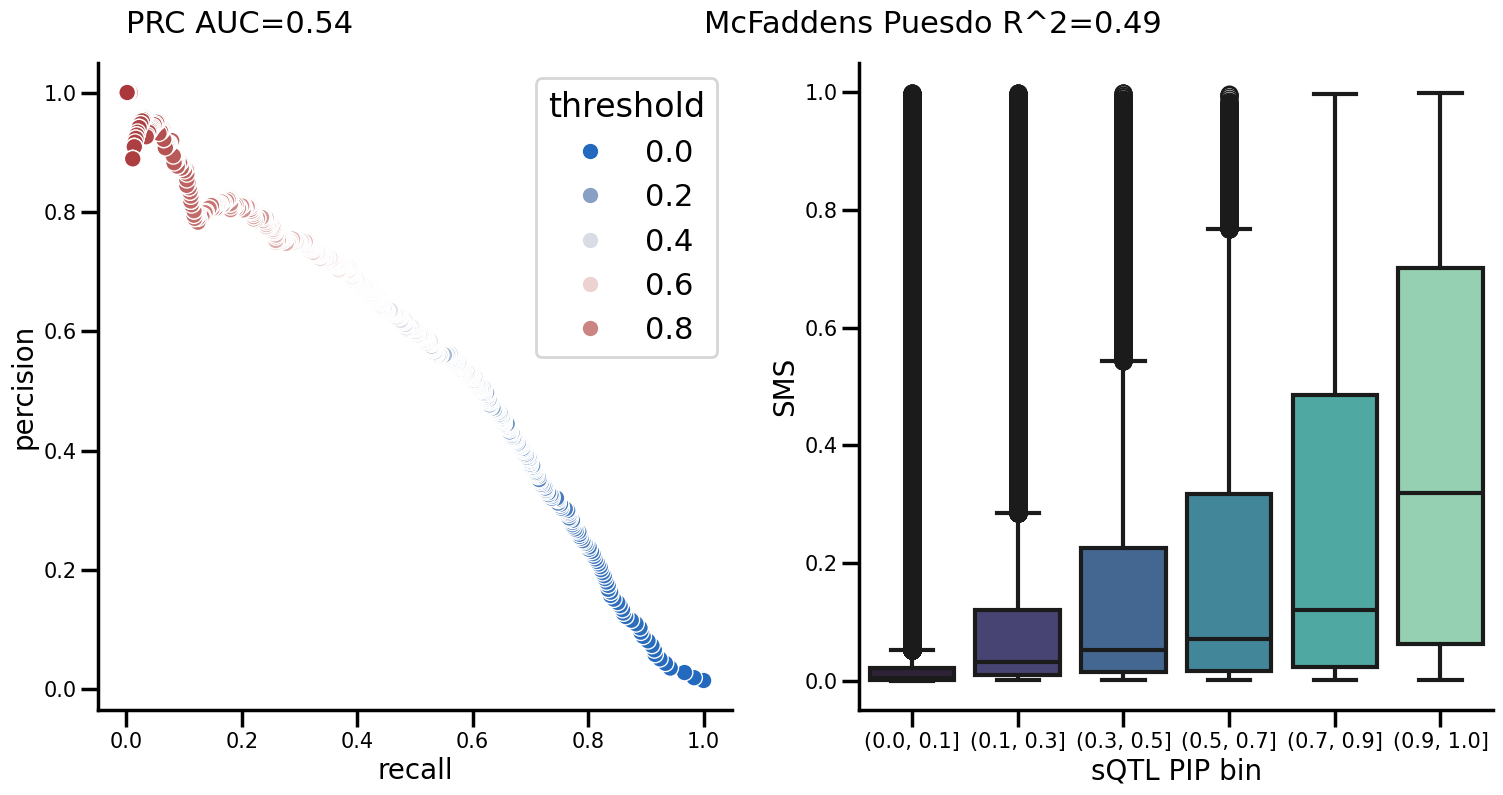

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15*1.2, 7*1.2), sharey=False)



pip_order=sorted(set(variants_affecting_phenotypes_within_5kb.sqtl_pip_bin))

prc=SMS.GLM.run_prc_over_thresholds(test_df_full, test_df_full.is_causal, test_df_full.predicted_prob_being_causal)
auc_precision_recall = auc(prc.recall, prc.precision)

AUC='PRC AUC='+str(round(auc_precision_recall,2))
axes[0].text(0, 1.1, AUC, fontsize = 22)
axes[0].set_xlabel('recall', size=20)
axes[0].set_ylabel('percision', size=20)

ax=sns.scatterplot(ax=axes[0],data=prc, x='recall', y='precision', hue="threshold", palette='vlag') 
axes[0].tick_params(axis='y', labelsize=15 )
axes[0].tick_params(axis='x', labelsize=15 )
r_squared='McFaddens Puesdo R^2='+str(round(puesdo_r_sq_full_model,2))
axes[0].text(1, 1.1, r_squared, fontsize = 22)

########full model
ax=sns.boxplot(ax=axes[1], data=model_output_full, x='sqtl_pip_bin', y='predicted_prob_being_causal', order=sorted(set(variants_affecting_phenotypes_within_5kb.sqtl_pip_bin)), palette=mako_pal, linewidth=3) 

axes[1].set_xlabel('sQTL PIP bin', size=20)
axes[1].set_ylabel('SMS', size=20)
axes[1].tick_params(axis='y', labelsize=15 )
axes[1].tick_params(axis='x', labelsize=15 )

sns.despine()
fig.savefig(plot_directory+'SMS_full_model_prc_and_boxplot.png')



ValueError: Could not interpret value `recall` for `x`. An entry with this name does not appear in `data`.

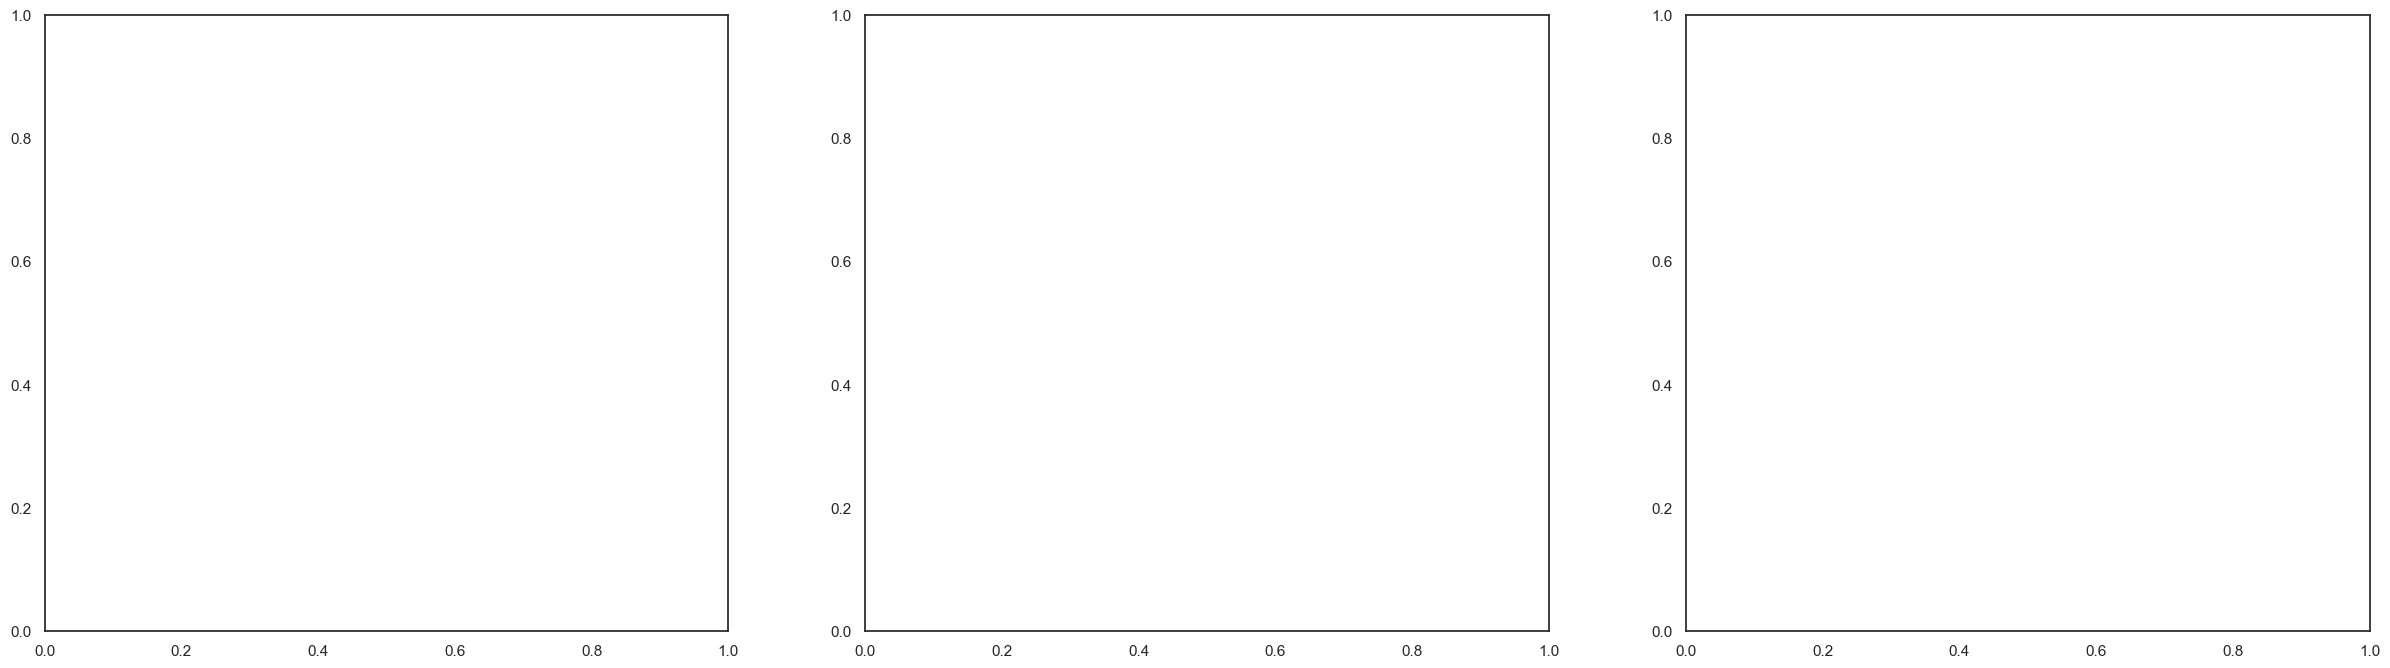

In [52]:
sns.set_style("white")
fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharey=False)


sns.lineplot(ax=axes[0], data=prcs_df, x='recall', y='precision', hue='cutoff', palette='Blues', linewidth=3)

for_plot=pd.DataFrame({'pip_cutoff':[0.5, 0.7, 0.8, 0.9, 0.95], 'ratio_neg_to_pos':ratio_neg_to_pos, 'r2':puesdo_r_sq_full_model_upsampled})

sns.scatterplot(ax=axes[1], data=for_plot, x='pip_cutoff', y='r2', palette='Blues', hue='pip_cutoff', s = 200, edgecolor="black" )

axes[1].set_xlabel('PIP cutoff', size=20)

axes[1].set_ylabel('puesdo R^2 value', size=15)


sns.barplot(ax=axes[2], x="pip_cutoff", y="ratio_neg_to_pos", data=for_plot, palette='Blues')

axes[2].set_ylabel('Fold higher - class is represented over + class', size=15)


In conclusion: this doesnt really change the PRC curve, but does reduce accuracy via puesdo R^2 value.


In [ ]:
from numpy.linalg import inv
[model_fit_full, train_df_full, test_df_full, model_output_full]=SMS.GLM.run_model(variants_affecting_phenotypes_within_5kb, 0.9, 0.002, 'default_features', 'w_gtex_distances')


In [ ]:
[model_fit_full_given_cuttoff, train_fit_full_given_cuttoff, test_fit_full_given_cuttoff, model_df_full_given_cuttoff]=SMS.GLM.run_model(variants_affecting_phenotypes_within_5kb, 0.95, 0.002, 'default_features', 'w_gtex_distances')
    

In [ ]:
SMS.GLM.run_prc_over_thresholds(test_df_full, test_df_full.is_causal, test_df_full.predicted_prob_being_causal_ds)
    

In [ ]:

neg_set_pip=0.002
negative_set=variants_affecting_phenotypes_within_5kb[variants_affecting_phenotypes_within_5kb.pip<=neg_set_pip]

positive_set=variants_affecting_phenotypes_within_5kb[variants_affecting_phenotypes_within_5kb.pip>=0.9]

puesdo_r_sq_full_model_downsampled=[]

prcs_df_downsampled=pd.DataFrame([])

auc_precision_recall_downsampled=[]

pip_cutoff=0.9

ratio_neg_to_pos=[]
for frac_to_downsample in [1, 1/2, 1/4, 1/10, 1/20, 1/40]:
    
    new_negative_set=negative_set.sample(frac=frac_to_downsample, replace=False)
    
    for_model=pd.concat([new_negative_set, positive_set])
    
    [model_fit_full_given_cuttoff, train_df_full_given_cutoff, test_df_full_given_cutoff, model_output_full_given_cutoff]=SMS.GLM.run_model(for_model, pip_cutoff, 0.002, 'default_features', 'w_gtex_distances')
    
    #predict on same test set
    ypred_test = model_fit_full_given_cuttoff.predict(test_df_full)
    
    test_df_full=test_df_full.assign(predicted_prob_being_causal = ypred_test) 
        
    prc=SMS.GLM.run_prc_over_thresholds(test_df_full, test_df_full.is_causal, test_df_full.predicted_prob_being_causal)
    
 
    auc_precision_recall_downsampled.append(auc(prc.recall, prc.precision))
    
    prc['downsample']=str(1 / (frac_to_downsample)) + ' X'
    
    prcs_df_downsampled=prcs_df_downsampled.append(prc)

    pos=sum(model_output_full.pip>=pip_cutoff)
    neg=sum(model_output_full.pip<=0.002)*frac_to_downsample

    ratio_neg_to_pos.append(neg/pos)
    
    puesdo_r_sq_full_model_downsampled.append(SMS.GLM.print_puesdo_r(model_fit_full_given_cuttoff.llf, SMS.GLM.null_model_given_training_set(train_df_full_given_cutoff).llf, False, ' of full model'))
    

In [ ]:

sns.set_style("white")
fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharey=False)

list_downsampled=[str(1/x)+' X' for x in [1, 1/2, 1/4, 1/10, 1/20, 1/40]]

sns.lineplot(ax=axes[0], data=prcs_df_downsampled, x='recall', y='precision', hue='downsample', palette='Blues', linewidth=3)

for_plot=pd.DataFrame({'fraction_downsampled':list_downsampled, 'r2':puesdo_r_sq_full_model_downsampled})


sns.scatterplot(ax=axes[1], data=for_plot, x='fraction_downsampled', y='r2', palette='Blues', hue='fraction_downsampled', s = 200, edgecolor="black" )

axes[1].set_xlabel('fraction downsampled', size=20)

axes[1].set_ylabel('puesdo R^2 value', size=15)

for_plot=for_plot.assign(ratio_neg_to_pos=ratio_neg_to_pos)
sns.barplot(ax=axes[2], x="fraction_downsampled", y="ratio_neg_to_pos", data=for_plot, palette='Blues')

axes[2].set_ylabel('Fraction of - class over + class', size=15)

for_plot['AUC']=auc_precision_recall_downsampled


https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290

In [369]:



cred_int_across_thres_upper=[]
cred_int_across_thres_lower=[]

for thres in prc.threshold:
    test_df_given_thres=test_df_full[test_df_full.predicted_prob_being_causal>=thres]
    ci_given_thres=(ci(sum(test_df_given_thres.is_causal), len(test_df_given_thres), alpha=0.05))
    cred_int_across_thres_upper.append(ci_given_thres[0])
    cred_int_across_thres_lower.append(ci_given_thres[1])
    

x=prc.threshold
y=prc.precision
fig, ax = plt.subplots()
ax.plot(x,y)
ax.fill_between(x, (y-cred_int_across_thres_lower), (y+cred_int_across_thres_upper), color='b', alpha=.1)

ax.set_xlabel('Prob Threshold')

ax.set_ylabel('Precision+/- uncertainity')

In [36]:
#Training the model using mode of target
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix


from sklearn.linear_model import LogisticRegression

y_test=test_df_full.is_causal

pred_test=test_df_full['predicted_prob_being_causal']

f1_test = f1_score(ypred_test, pred_test)

test_df_full=test_df_full[~test_df_full.predicted_prob_being_causal.isna()]

test_df_full['causal_by_SMS']=test_df_full.predicted_prob_being_causal>=0.9



#y_true: array-like, or label indicator array / sparse matrix
#Ground truth (correct) target values.

#y_pred: array-like, or label indicator array / sparse matrix
#Estimated targets as returned by a classifier.



#Printing f1 and accuracy scores    
print('The accuracy for mode model is:', accuracy_score(y_test, pred_test))
print('The f1 score for the model model is:',f1_score(y_test, pred_test))

#Ploting the cunfusion matrix
conf_matrix(y_test, pred_test)

In [1]:
#add AF

path='/Users/hnjacobs/Documents/MAF_calc_gnomAD/'
file='allele_freq_GTEx.csv'
AF_df = pd.read_csv(path+'allele_freq_GTEx.csv')


AF_df['chromosome'] = 'chr' + AF_df['seqnames'].astype('str') 

AF_df['v_start']=AF_df['start']

#chromosome='chr'+variants_affecting_phenotypes_within_5kb.chromosome.astype('str')

#sqtl_df=sqtl_df.assign(chromosome=chromosome)

variants_affecting_phenotypes_within_5kb=variants_affecting_phenotypes_within_5kb.merge(AF_df[['chromosome', 'v_start', 'AF']], on=['chromosome'], how='left')       

NameError: name 'pd' is not defined

In [88]:
negative_set_same_gene=negative_set[negative_set.gene_name.isin(positive_set.gene_name)]


new_negative_set=negative_set_same_gene.sample(frac=1, replace=False)
    
for_model=pd.concat([new_negative_set, positive_set])
    
pip_cutoff=0.9
    
[model_fit_full, train_df_full, test_df_full, model_output_full]=SMS.GLM.run_model(for_model, pip_cutoff, 0.002, 'default_features', 'w_gtex_distances')
    
puesdo_r_sq_full_model=SMS.GLM.print_puesdo_r(model_fit_full.llf, SMS.GLM.null_model_given_training_set(train_df_full).llf, False, ' of full model')

    

the puesdo_r_sq is 0.5507854597302655 of full model


Text(0.7, 1.1, 'AUC=0.82')

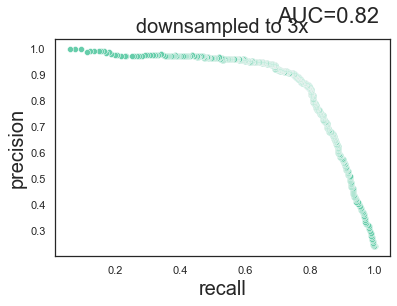

In [177]:
prc=SMS.GLM.run_prc_over_thresholds(test_df_full, test_df_full.is_causal, test_df_full.predicted_prob_being_causal)
auc_precision_recall = auc(prc.recall, prc.precision)
ax=sns.scatterplot(data=prc, x='recall', y='precision', color=colors[i])
ax.set_xlabel('recall', size=20)
ax.set_ylabel('precision', size=20)
ax.set_title('downsampled to 3x', size=20)
auc_precision_recall = auc(prc.recall, prc.precision)
AUC='AUC='+str(round(auc_precision_recall,2))
ax.text(0.7, 1.1, AUC, fontsize = 22)

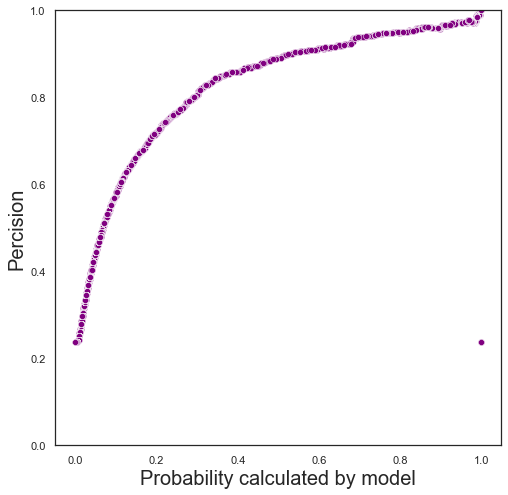

In [181]:
prc=SMS.GLM.run_prc_over_thresholds(test_df_full, test_df_full.is_causal, test_df_full.predicted_prob_being_causal)
model_output_full=SMS.GLM.get_percision_given_prc_curve(model_output_full, prc)




fig, axes = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
ax=sns.scatterplot(data=model_output_full, x='predicted_prob_being_causal', y='precision', color='purple')

ax.set_ylabel('Percision', size=20)
ax.set_xlabel('Probability calculated by model', size=20)
ax.set_ylim([0,1])
fig.savefig(plot_directory+'SMS_full_model_percision_vs_SMS_score.png')

In [ ]:
test_df_full.predicted_prob_being_causal

In [99]:
features='+ in_oRNAment +in_eCLIP + either_ESE + either_ESS  + DHS_Trynka + + H3K27ac_PGC2 + TSS_Hoffman + TFBS_ENCODE + H3K27ac_PGC2 + H3K9ac_Trynka  + H3K4me1_Trynka + H3K4me3_Trynka + Enhancer_Hoffman + Transcribed_Hoffman +gc_twenty_bp +phastcons_100'
[model_fit_wo_promoter, train_df_wo_promoter, test_df_wo_promoter, model_output_wo_promoter]=SMS.GLM.run_model(variants_affecting_phenotypes_within_5kb, 0.95, 0.002, features, 'w_gtex_distances')


In [100]:
from SMS import plots
from SMS.plots import *

reload(SMS.plots)
from SMS.plots import *

In [101]:
region_number=variants_affecting_phenotypes_within_5kb.annot_info.apply(lambda x: int(x.split('_')[2]))


variants_affecting_phenotypes_within_5kb=variants_affecting_phenotypes_within_5kb.assign(region_number=region_number)






test_without_first_exons = variants_affecting_phenotypes_within_5kb[variants_affecting_phenotypes_within_5kb.region_number>=1]

[model_fit_full_without_first_exons, train_df_full_without_first_exons, test_df_full_without_first_exons, model_output_full_without_first_exons]=SMS.GLM.run_model(test_without_first_exons, 0.95, 0.002, 'default_features', 'w_gtex_distances')


In [23]:

#SMS.GLM.print_puesdo_r(model_fit_wo_promoter.llf, SMS.GLM.null_model_given_training_set(train_df_wo_promoter).llf, False,' not promoters')


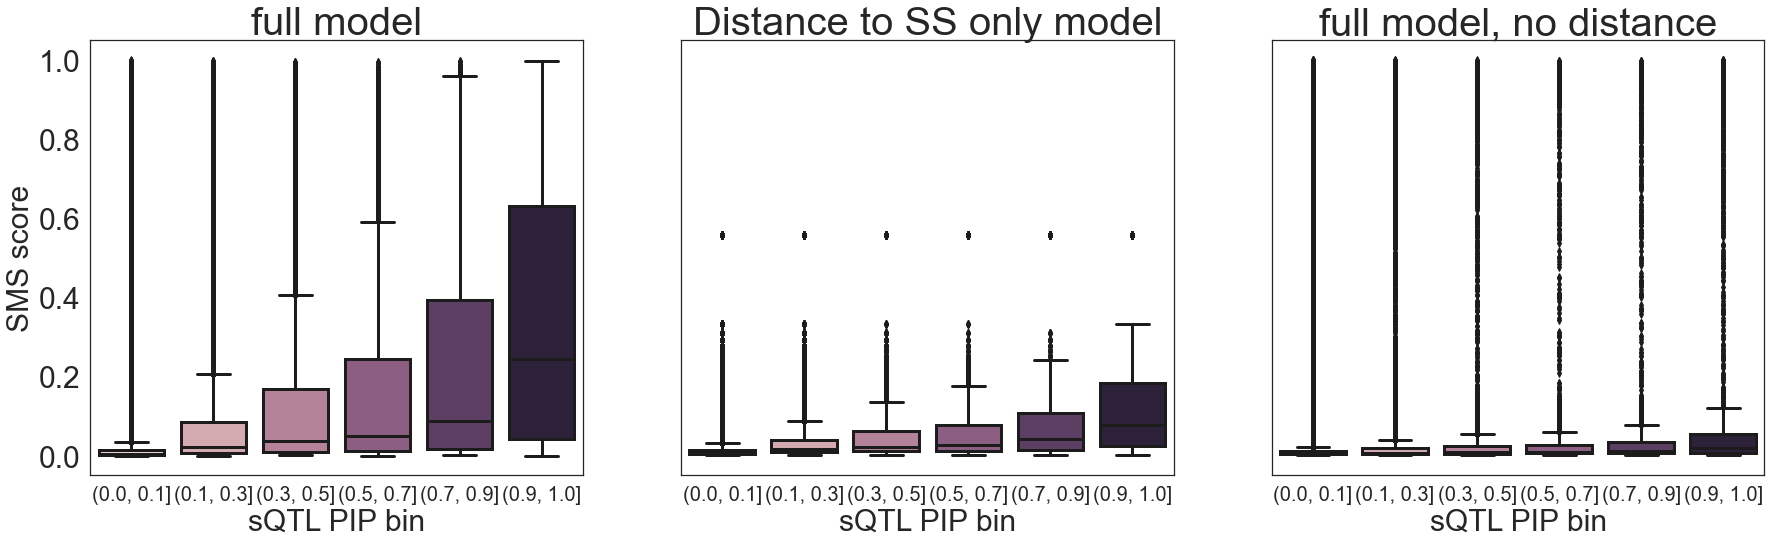

In [22]:
cmap = sns.cubehelix_palette(as_cmap=False)

fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharey=True)

########full model
ax=sns.boxplot(ax=axes[0], data=model_output_full, x='sqtl_pip_bin', y='predicted_prob_being_causal', order=sorted(set(variants_affecting_phenotypes_within_5kb.sqtl_pip_bin)), palette=cmap, linewidth=3) 
axes[0].set_title('full model', size=40)
axes[0].set_xlabel('sQTL PIP bin', size=30)
axes[0].set_ylabel('SMS score', size=30)
axes[0].tick_params(axis='y', labelsize=30 )
axes[0].tick_params(axis='x', labelsize=20 )

########gtex distance
ax=sns.boxplot(ax=axes[1], data=model_output_gtex_dist, x='sqtl_pip_bin', y='predicted_prob_being_causal', order=sorted(set(variants_affecting_phenotypes_within_5kb.sqtl_pip_bin)), palette=cmap, linewidth=3) 
axes[1].set_title('Distance to SS only model', size=40)
axes[1].set_xlabel('sQTL PIP bin', size=30)
axes[1].set_ylabel('', size=20)
axes[1].tick_params(axis='y', labelsize=30 )
axes[1].tick_params(axis='x', labelsize=20 )


########no distance, all other features
ax=sns.boxplot(ax=axes[2], data=model_output_no_dists, x='sqtl_pip_bin', y='predicted_prob_being_causal', order=sorted(set(variants_affecting_phenotypes_within_5kb.sqtl_pip_bin)), palette=cmap, linewidth=3) 
axes[2].set_title('full model, no distance', size=40)
axes[2].set_xlabel('sQTL PIP bin', size=30)
axes[2].set_ylabel('', size=20)
axes[2].tick_params(axis='y', labelsize=30 )
axes[2].tick_params(axis='x', labelsize=20 )
fig.savefig(plot_directory+'SMS_full_model_gtex_dist_and_no_dist.png')


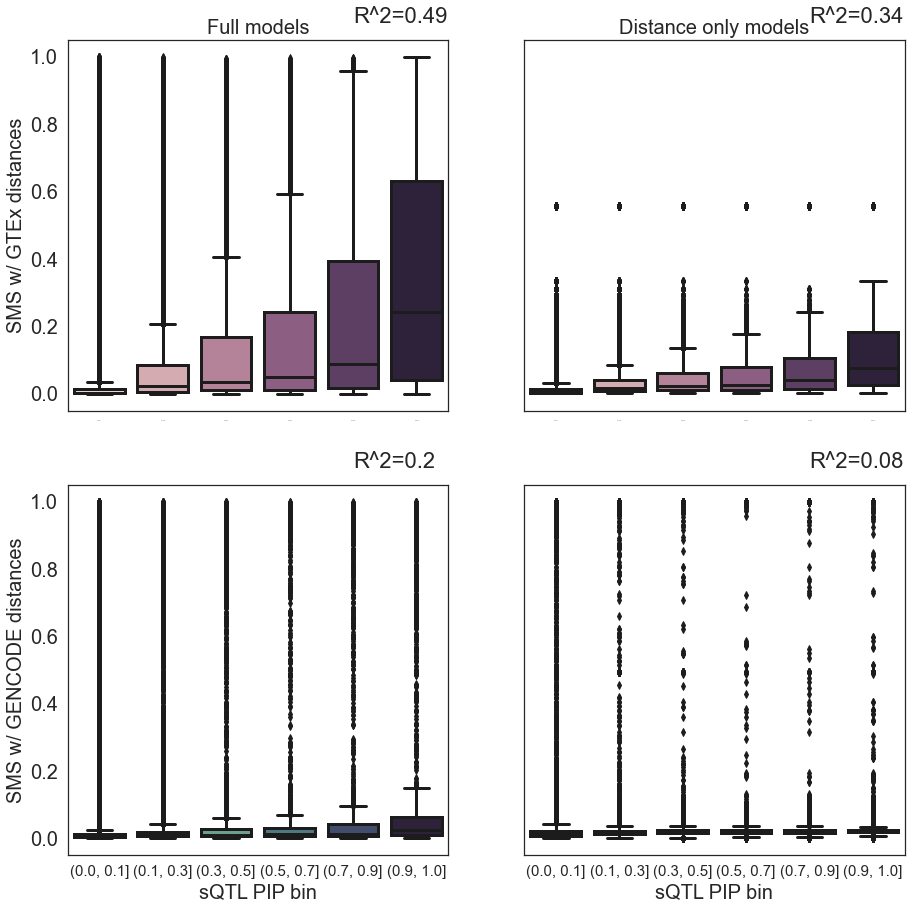

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True)



pip_order=sorted(set(variants_affecting_phenotypes_within_5kb.sqtl_pip_bin))
cmap = sns.cubehelix_palette(as_cmap=False)


########full model
ax=sns.boxplot(ax=axes[0,0], data=model_output_full, x='sqtl_pip_bin', y='predicted_prob_being_causal', order=sorted(set(variants_affecting_phenotypes_within_5kb.sqtl_pip_bin)), palette=cmap, linewidth=3) 
axes[0,0].set_title('Full models', size=20)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('SMS w/ GTEx distances', size=20)
axes[0,0].tick_params(axis='y', labelsize=20 )
axes[0,0].tick_params(axis='x', labelsize=1 )
r_squared='R^2='+str(round(puesdo_r_sq_full_model,2))
axes[0,0].text(4, 1.1, r_squared, fontsize = 22)


########distance to gtex ss
ax=sns.boxplot(ax=axes[0,1], data=model_output_gtex_dist, x='sqtl_pip_bin', y='predicted_prob_being_causal', order=sorted(set(variants_affecting_phenotypes_within_5kb.sqtl_pip_bin)), palette=cmap, linewidth=3) 
axes[0,1].set_title('Distance only models', size=20)
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')
axes[0,1].tick_params(axis='x', labelsize=1 )
r_squared='R^2='+str(round(puesdo_r_sq_gtex_dist,2))
cmap_dist=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=False)

model_output_gencode_dist

#######full model, gencode only
axes[0,1].text(4, 1.1, r_squared, fontsize = 22)

ax=sns.boxplot(ax=axes[1,0], data=model_output_full_but_gencode_dist, x='sqtl_pip_bin', y='predicted_prob_being_causal', order=sorted(set(variants_affecting_phenotypes_within_5kb.sqtl_pip_bin)), palette=cmap_dist, linewidth=3) 

axes[1,0].set_xlabel('sQTL PIP bin', size=20)
axes[1,0].set_ylabel('SMS w/ GENCODE distances', size=20)
axes[1,0].tick_params(axis='x', labelsize=15 )
axes[1,0].tick_params(axis='y', labelsize=20 )
r_squared='R^2='+str(round(puesdo_r_sq_full_gencode,2))
axes[1,0].text(4, 1.1, r_squared, fontsize = 22)

#######distance model, gencode only

ax=sns.boxplot(ax=axes[1,1], data=model_output_gencode_dist, x='sqtl_pip_bin', y='predicted_prob_being_causal', order=sorted(set(variants_affecting_phenotypes_within_5kb.sqtl_pip_bin)), palette=cmap_dist, linewidth=3) 

axes[1,1].set_xlabel('sQTL PIP bin', size=20)
axes[1,1].set_ylabel('', size=20)
axes[1,1].tick_params(axis='x', labelsize=15 )
r_squared='R^2='+str(round(puesdo_r_sq_gencode_dist,2))
axes[1,1].text(4, 1.1, r_squared, fontsize = 22)


fig.savefig(plot_directory+'SMS_full_model_gtex_dist_and_no_dist.png')


In [31]:
model_output_full['common_variant']=model_output_full.AF>=0.05
model_output_full['common_variant']=model_output_full['common_variant'].replace(False, 'rare')
model_output_full['common_variant']=model_output_full['common_variant'].replace(True, 'common')

fig,  axes = plt.subplots(1, 1, figsize=(10, 8), sharey=True)
sns.set_theme(style="white")

colors=['lightsteelblue', 'cornflowerblue', 'royalblue', 'mediumblue', 'darkblue', 'navy']
#fig, (ax1, ax2) = plt.subplots(1, 2)

ax1=sns.boxplot(data=model_output_full, x='sqtl_pip_bin', y='predicted_prob_being_causal', order=sorted(set(variants_affecting_phenotypes_within_5kb.sqtl_pip_bin)), palette='Greens', linewidth=3, hue='common_variant') 
                          # medianprops=dict(color="white", alpha=0.7))
            #flierprops=dict(markerfacecolor="#707070", marker="d"))



ax1.set_xlabel('PIP bin', size=20)

ax1.set_ylabel('model prediction', size=20)

ax1.legend(loc='upper left')

fig.savefig(plot_dir+'SMS_model_pred_rare_vs_common_variants.png')


AttributeError: 'DataFrame' object has no attribute 'AF'

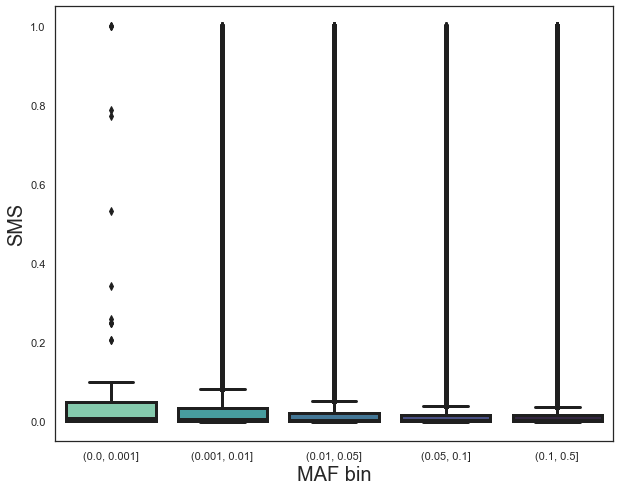

In [198]:
full_model_output['MAF_bin']=pd.cut(full_model_output['AF'], [0, 0.001, 0.01, 0.05, 0.1, 0.5])

fig,  axes = plt.subplots(1, 1, figsize=(10, 8), sharey=True)
sns.set_theme(style="white")

colors=['lightsteelblue', 'cornflowerblue', 'royalblue', 'mediumblue', 'darkblue', 'navy']
#fig, (ax1, ax2) = plt.subplots(1, 2)

ax1=sns.boxplot(data=full_model_output[~full_model_output.AF.isna()], x='MAF_bin', y='predicted_prob_being_causal', palette='mako_r', linewidth=3) 
                          # medianprops=dict(color="white", alpha=0.7))
            #flierprops=dict(markerfacecolor="#707070", marker="d"))



ax1.set_xlabel('MAF bin', size=20)

ax1.set_ylabel('SMS', size=20)


fig.savefig(plot_dir+'SMS_model_across_MAF_bin.png')


Text(0, 0.5, 'SMS using continious distance')

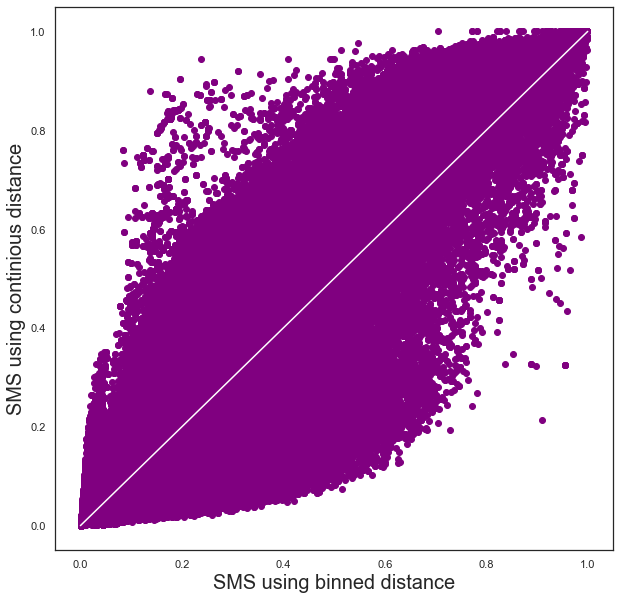

In [147]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharey=True)

ax=plt.scatter(model_output_full.predicted_prob_being_causal, model_output_full_cont_dist.predicted_prob_being_causal, color='purple')

plt.plot( [0,1],[0,1], color='w')

plt.xlabel('SMS using binned distance', size=20)

plt.ylabel('SMS using continious distance', size=20)

Text(0.7, 1.1, 'AUC=0.5')

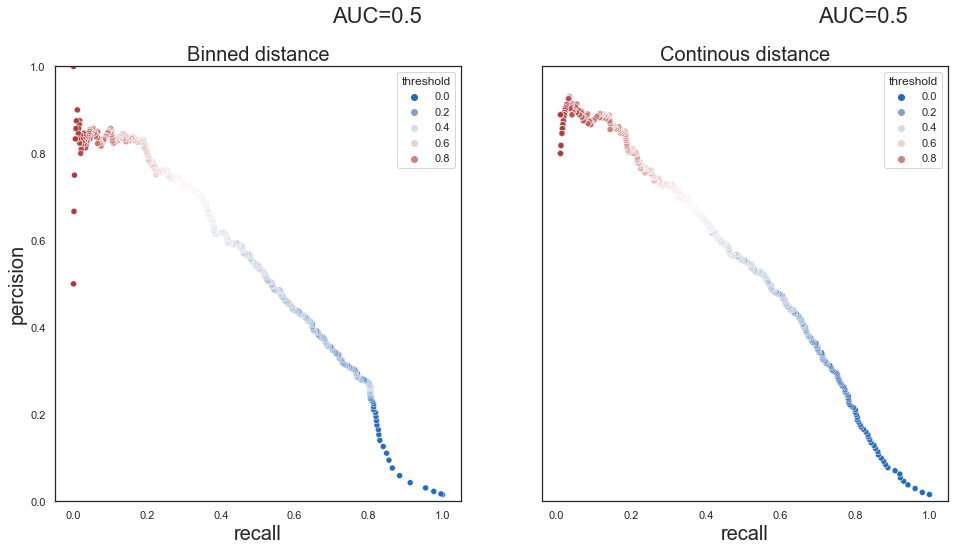

In [238]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

###########gencode full model#############
prc=SMS.GLM.run_prc_over_thresholds(test_df_full, test_df_full.is_causal, test_df_full.predicted_prob_being_causal)

ax=sns.scatterplot(ax=axes[0],data=prc, x='recall', y='precision', hue="threshold",palette='vlag') 

axes[0].set_ylabel('percision', size=20)
axes[0].set_xlabel('recall', size=20)
axes[0].set_ylim([0,1])
axes[0].set_title('Binned distance', size=20)
auc_precision_recall = auc(prc.recall, prc.precision)
AUC='AUC='+str(round(auc_precision_recall,2))
axes[0].text(0.7, 1.1, AUC, fontsize = 22)

###########gencode full model#############
prc_cont=SMS.GLM.run_prc_over_thresholds(test_df_full_cont_dist, test_df_full_cont_dist.is_causal, test_df_full_cont_dist.predicted_prob_being_causal)

ax=sns.scatterplot(ax=axes[1],data=prc_cont, x='recall', y='precision', hue="threshold",palette='vlag') 

axes[1].set_ylabel('percision', size=20)
axes[1].set_xlabel('recall', size=20)
axes[1].set_ylim([0,1])
axes[1].set_title('Continous distance', size=20)
auc_precision_recall = auc(prc.recall, prc.precision)
AUC='AUC='+str(round(auc_precision_recall,2))
axes[1].text(0.7, 1.1, AUC, fontsize = 22)

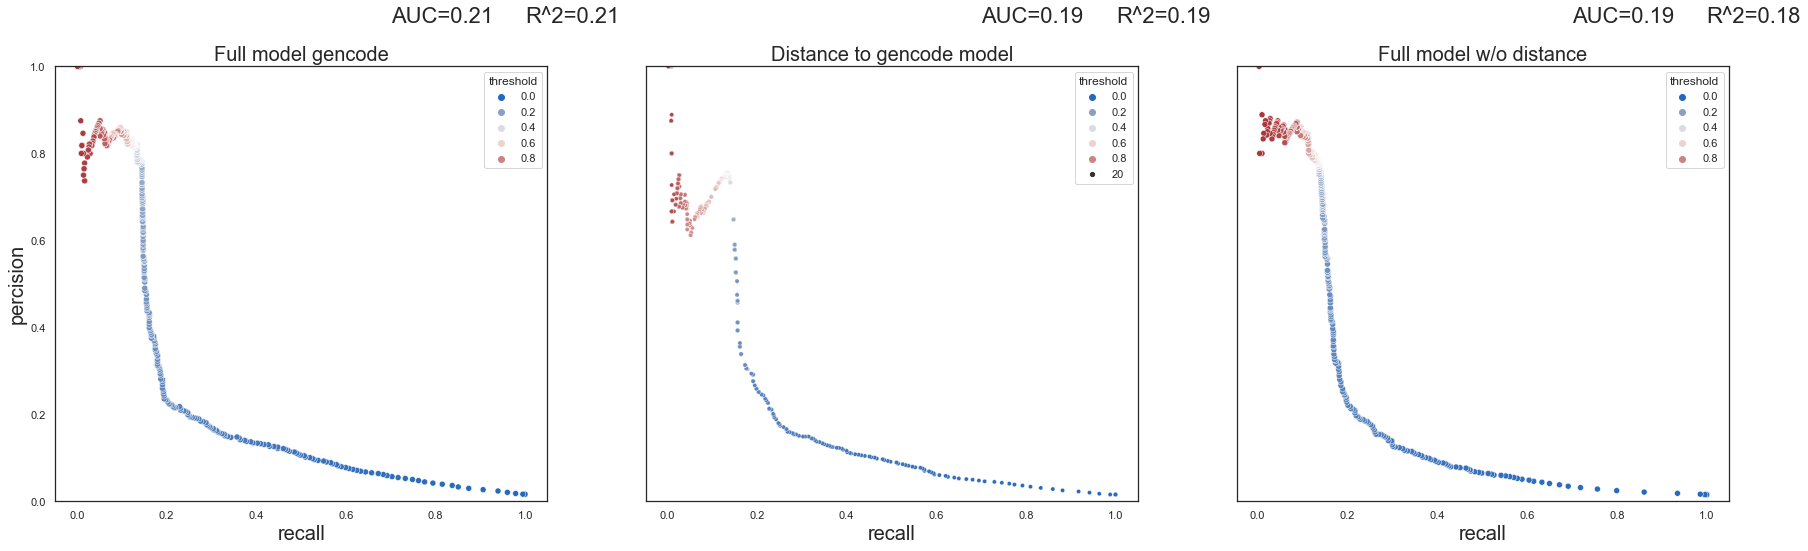

In [52]:


fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharey=True)

###########gencode full model#############
prc=SMS.GLM.run_prc_over_thresholds(test_df_full_but_gencode_dist, test_df_full_but_gencode_dist.is_causal, test_df_full_but_gencode_dist.predicted_prob_being_causal)

ax=sns.scatterplot(ax=axes[0],data=prc, x='recall', y='precision', hue="threshold",palette='vlag') 

axes[0].set_ylabel('percision', size=20)
axes[0].set_xlabel('recall', size=20)
axes[0].set_ylim([0,1])

auc_precision_recall = auc(prc.recall, prc.precision)
AUC='AUC='+str(round(auc_precision_recall,2))
axes[0].text(0.7, 1.1, AUC, fontsize = 22)

###########gencode distance#############

prc=SMS.GLM.run_prc_over_thresholds(test_df_gencode_dist, test_df_gencode_dist.is_causal, test_df_gencode_dist.predicted_prob_being_causal)

ax=sns.scatterplot(ax=axes[1],data=prc, x='recall', y='precision', hue="threshold",palette='vlag', size=20)
axes[1].set_xlabel('recall', size=20)

auc_precision_recall = auc(prc.recall, prc.precision)
AUC='AUC='+str(round(auc_precision_recall,2))
axes[1].text(0.7, 1.1, AUC, fontsize = 22)


###########no distance full model#############


prc=SMS.GLM.run_prc_over_thresholds(test_df_no_dists, test_df_no_dists.is_causal, test_df_no_dists.predicted_prob_being_causal)
ax=sns.scatterplot(ax=axes[2],data=prc, x='recall', y='precision', hue="threshold",palette='vlag')
ax.set_xlabel('recall', size=20)

auc_precision_recall = auc(prc.recall, prc.precision)
AUC='AUC='+str(round(auc_precision_recall,2))
axes[2].text(0.7, 1.1, AUC, fontsize = 22)


r_squared='R^2='+str(round(puesdo_r_sq_full_gencode,2))
axes[0].text(1, 1.1, r_squared, fontsize = 22)

r_squared='R^2='+str(round(puesdo_r_sq_gencode_dist,2))
axes[1].text(1, 1.1, r_squared, fontsize = 22)

r_squared='R^2='+str(round(puesdo_r_sq_no_dist,2))
axes[2].text(1, 1.1, r_squared, fontsize = 22)


axes[0].set_title('Full model gencode', size=20)
axes[1].set_title('Distance to gencode model', size=20)
axes[2].set_title('Full model w/o distance', size=20)


fig.savefig(plot_directory+'SMS_full_model_gencode_dist_and_no_dist_PRC.png')

In [57]:
prc[prc.precision>=0.8].recall.iloc[0]

0.1222366710013004

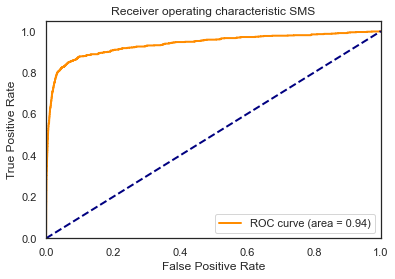

In [83]:
test_df_full=test_df_full[~test_df_full.predicted_prob_being_causal.isna()]

from sklearn import metrics
roc_auc=metrics.roc_auc_score(test_df_full.is_causal, test_df_full.predicted_prob_being_causal)

metrics.roc_curve(test_df_full.is_causal, test_df_full.predicted_prob_being_causal, pos_label=1)



[fpr, tpr, thresholds]=metrics.roc_curve(test_df_full.is_causal, test_df_full.predicted_prob_being_causal, pos_label=1)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic SMS")
plt.legend(loc="lower right")
plt.show()

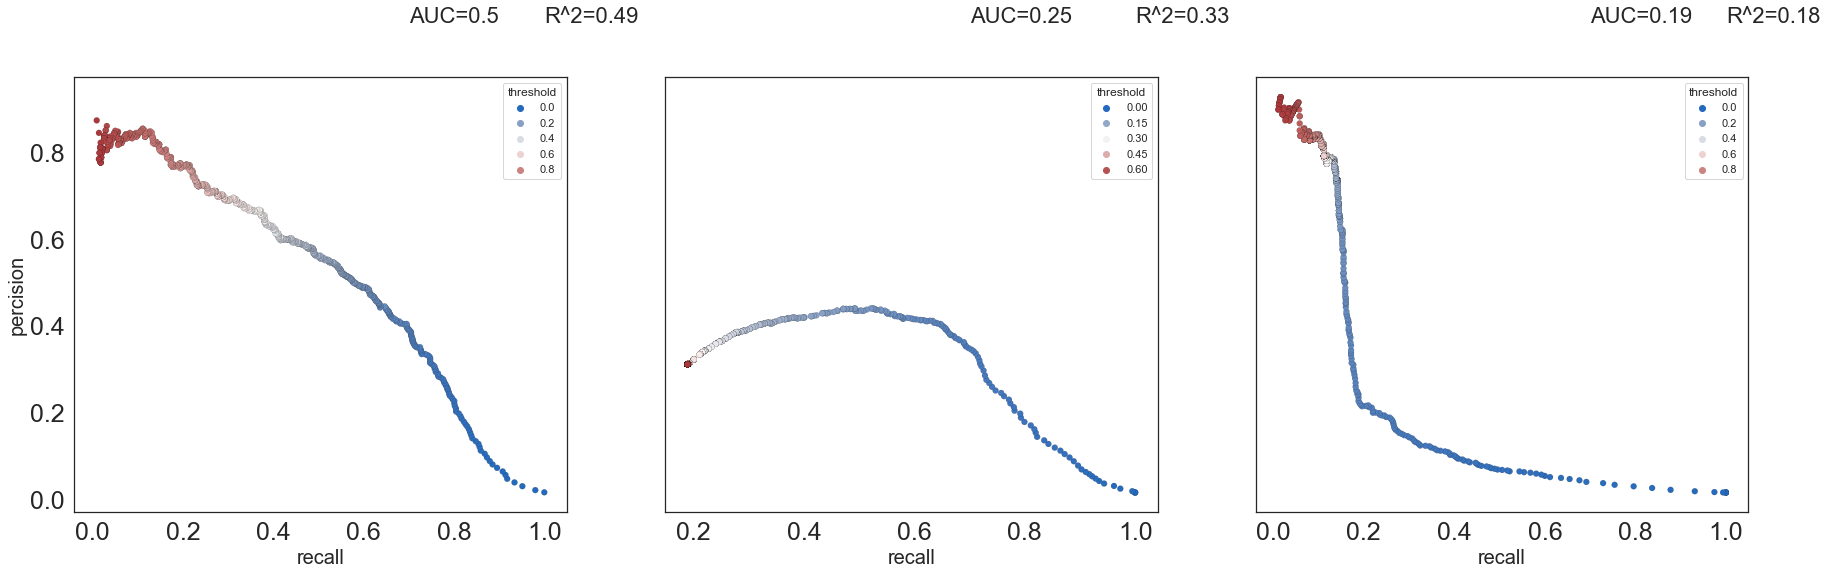

In [35]:

fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharey=True)

prc=SMS.GLM.run_prc_over_thresholds(test_df_full, test_df_full.is_causal, test_df_full.predicted_prob_being_causal)
auc_precision_recall = auc(prc.recall, prc.precision)

AUC='AUC='+str(round(auc_precision_recall,2))
axes[0].text(0.7, 1.1, AUC, fontsize = 22)
axes[0].set_xlabel('recall', size=20)
axes[0].set_ylabel('percision', size=20)
ax=sns.scatterplot(ax=axes[0],data=prc, x='recall', y='precision', palette='vlag', hue="threshold", linewidth=0.1, edgecolor='black')
axes[0].tick_params(axis='x', labelsize=25 )
axes[0].tick_params(axis='y', labelsize=25 )

prc=SMS.GLM.run_prc_over_thresholds(test_df_gtex_dist, test_df_gtex_dist.is_causal, test_df_gtex_dist.predicted_prob_being_causal)

auc_precision_recall = auc(prc.recall, prc.precision)
AUC='AUC='+str(round(auc_precision_recall,2))
axes[1].text(0.7, 1.1, AUC, fontsize = 22)
ax=sns.scatterplot(ax=axes[1],data=prc, x='recall', y='precision', palette='vlag', hue="threshold", linewidth=0.1, edgecolor='black')
axes[1].set_xlabel('recall', size=20)
axes[1].tick_params(axis='x', labelsize=25 )

prc=SMS.GLM.run_prc_over_thresholds(test_df_no_dists, test_df_no_dists.is_causal, test_df_no_dists.predicted_prob_being_causal)
ax=sns.scatterplot(ax=axes[2],data=prc, x='recall', y='precision', palette='vlag', hue="threshold",linewidth=0.1, edgecolor='black')
ax.set_xlabel('recall', size=20)
axes[2].tick_params(axis='x', labelsize=25 )
auc_precision_recall = auc(prc.recall, prc.precision)
AUC='AUC='+str(round(auc_precision_recall,2))
axes[2].text(0.7, 1.1, AUC, fontsize = 22)


r_squared='R^2='+str(round(puesdo_r_sq_full_model,2))
axes[0].text(1, 1.1, r_squared, fontsize = 22)

r_squared='R^2='+str(round(puesdo_r_sq_gtex_dist,2))
axes[1].text(1, 1.1, r_squared, fontsize = 22)

r_squared='R^2='+str(round(puesdo_r_sq_no_dist,2))
axes[2].text(1, 1.1, r_squared, fontsize = 22)


#axes[0].set_title('Full model', size=20)
#axes[1].set_title('Distance to GTEx ss model', size=20)
#axes[2].set_title('Full model w/o GTEx distance', size=20)

fig.savefig(plot_directory+'SMS_full_model_gtex_dist_and_no_dist_PRC.png')

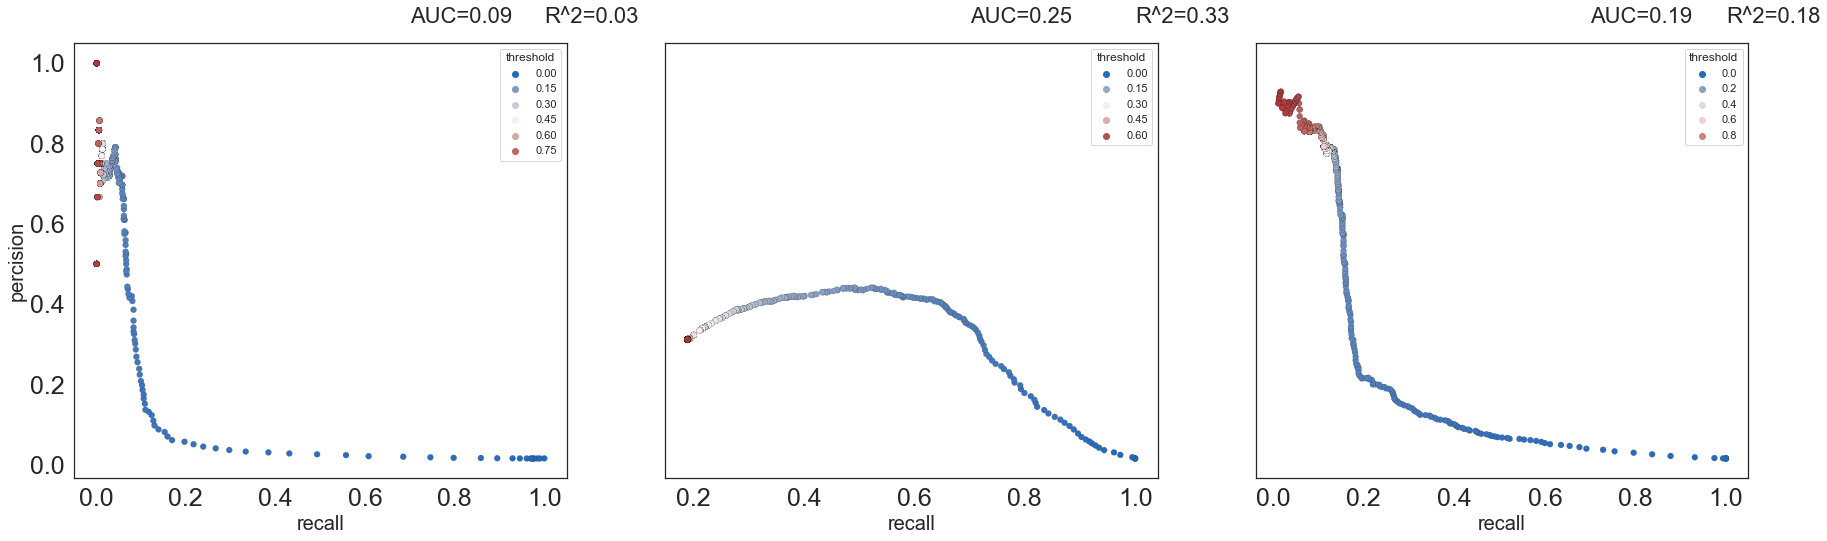

In [36]:

fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharey=True)

prc=SMS.GLM.run_prc_over_thresholds(test_df_maxent, test_df_maxent.is_causal, test_df_maxent.predicted_prob_being_causal)
auc_precision_recall = auc(prc.recall, prc.precision)

AUC='AUC='+str(round(auc_precision_recall,2))
axes[0].text(0.7, 1.1, AUC, fontsize = 22)
axes[0].set_xlabel('recall', size=20)
axes[0].set_ylabel('percision', size=20)
ax=sns.scatterplot(ax=axes[0],data=prc, x='recall', y='precision', palette='vlag', hue="threshold", linewidth=0.1, edgecolor='black')
axes[0].tick_params(axis='x', labelsize=25 )
axes[0].tick_params(axis='y', labelsize=25 )

prc=SMS.GLM.run_prc_over_thresholds(test_df_gtex_dist, test_df_gtex_dist.is_causal, test_df_gtex_dist.predicted_prob_being_causal)

auc_precision_recall = auc(prc.recall, prc.precision)
AUC='AUC='+str(round(auc_precision_recall,2))
axes[1].text(0.7, 1.1, AUC, fontsize = 22)
ax=sns.scatterplot(ax=axes[1],data=prc, x='recall', y='precision', palette='vlag', hue="threshold", linewidth=0.1, edgecolor='black')
axes[1].set_xlabel('recall', size=20)
axes[1].tick_params(axis='x', labelsize=25 )

prc=SMS.GLM.run_prc_over_thresholds(test_df_no_dists, test_df_no_dists.is_causal, test_df_no_dists.predicted_prob_being_causal)
ax=sns.scatterplot(ax=axes[2],data=prc, x='recall', y='precision', palette='vlag', hue="threshold",linewidth=0.1, edgecolor='black')
ax.set_xlabel('recall', size=20)
axes[2].tick_params(axis='x', labelsize=25 )
auc_precision_recall = auc(prc.recall, prc.precision)
AUC='AUC='+str(round(auc_precision_recall,2))
axes[2].text(0.7, 1.1, AUC, fontsize = 22)


r_squared='R^2='+str(round(puesdo_r_sq_maxent,2))
axes[0].text(1, 1.1, r_squared, fontsize = 22)

r_squared='R^2='+str(round(puesdo_r_sq_gtex_dist,2))
axes[1].text(1, 1.1, r_squared, fontsize = 22)

r_squared='R^2='+str(round(puesdo_r_sq_no_dist,2))
axes[2].text(1, 1.1, r_squared, fontsize = 22)


#axes[0].set_title('Full model', size=20)
#axes[1].set_title('Distance to GTEx ss model', size=20)
#axes[2].set_title('Full model w/o GTEx distance', size=20)

fig.savefig(plot_directory+'SMS_full_model_gtex_dist_maxent.png')

Full model PrC and performance on int variants

In [149]:
cmap = sns.cubehelix_palette(as_cmap=False)

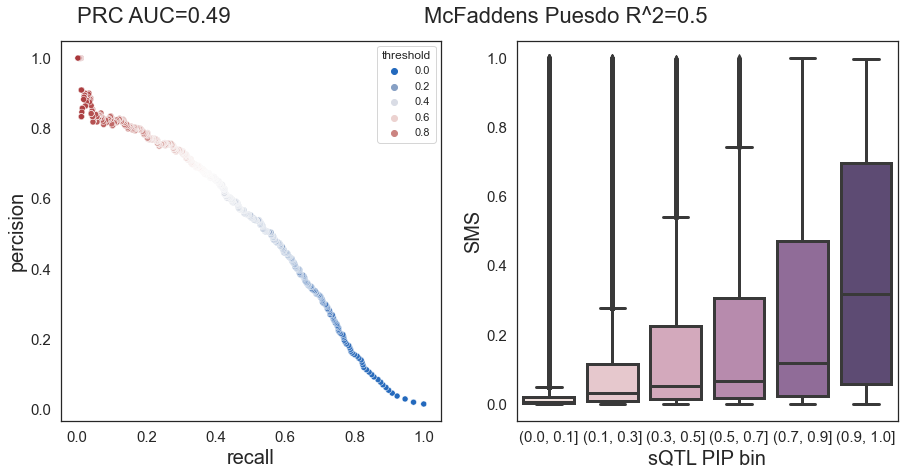

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=False)



pip_order=sorted(set(variants_affecting_phenotypes_within_5kb.sqtl_pip_bin))
cmap = sns.cubehelix_palette(as_cmap=False, gamma=0.6)

prc=SMS.GLM.run_prc_over_thresholds(test_df_full, test_df_full.is_causal, test_df_full.predicted_prob_being_causal)
auc_precision_recall = auc(prc.recall, prc.precision)

AUC='PRC AUC='+str(round(auc_precision_recall,2))
axes[0].text(0, 1.1, AUC, fontsize = 22)
axes[0].set_xlabel('recall', size=20)
axes[0].set_ylabel('percision', size=20)

ax=sns.scatterplot(ax=axes[0],data=prc, x='recall', y='precision', hue="threshold", palette='vlag') 
axes[0].tick_params(axis='y', labelsize=15 )
axes[0].tick_params(axis='x', labelsize=15 )
r_squared='McFaddens Puesdo R^2='+str(round(puesdo_r_sq_full_model,2))
axes[0].text(1, 1.1, r_squared, fontsize = 22)

########full model
ax=sns.boxplot(ax=axes[1], data=model_output_full, x='sqtl_pip_bin', y='predicted_prob_being_causal', order=sorted(set(variants_affecting_phenotypes_within_5kb.sqtl_pip_bin)), palette=cmap, linewidth=3) 

axes[1].set_xlabel('sQTL PIP bin', size=20)
axes[1].set_ylabel('SMS', size=20)
axes[1].tick_params(axis='y', labelsize=15 )
axes[1].tick_params(axis='x', labelsize=15 )


fig.savefig(plot_directory+'SMS_full_model_prc_and_boxplot.png')



In [288]:
model_fit_coef=model_fit_full_cont_dist.params.to_frame(name='coef').reset_index()

model_fit_coef['pvalues']=np.array(model_fit_full_cont_dist.pvalues)


In [322]:


model_fit_coef=model_fit_coef[model_fit_coef['index']!='Intercept']

In [347]:


feature = model_fit_coef['index'][9:].apply(lambda x: x.split(':')[1])

region = model_fit_coef['index'][9:].apply(lambda x: x.split(':')[0].split('[')[1].split(']')[0])

In [348]:
model_fit_coef=model_fit_coef.assign(region=region)
model_fit_coef=model_fit_coef.assign(feature=feature)


In [349]:
model_fit_coef['region']=model_fit_coef['region'].replace({'True':'exon', 'False':'intron'})

In [350]:
model_fit_coef[:8]['region']='all'
model_fit_coef[:8]['feature']=model_fit_coef[:8]['index']

/var/folders/km/w07543ln7lbg2h8_nrl0wv880000gn/T/ipykernel_3104/1226247332.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_fit_coef[:8]['region']='all'
/var/folders/km/w07543ln7lbg2h8_nrl0wv880000gn/T/ipykernel_3104/1226247332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_fit_coef[:8]['feature']=model_fit_coef[:8]['index']


In [367]:
sig=model_fit_coef[model_fit_coef.pvalues>=0.01]

In [368]:
coef_heatmap=pd.pivot(sig, index='feature', columns='region', values='coef')

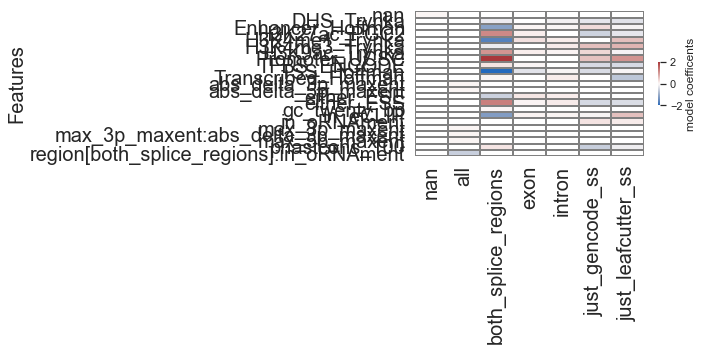

In [374]:



fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
    
ax=sns.heatmap(coef_heatmap, annot=False, cmap='vlag', center=0, vmax=2, vmin=-2, linewidth=2, linecolor='grey', cbar_kws={"shrink":0.3, 'label': 'model coefficents', 'location':'right'})
ax.set_ylabel('Features', size=20)
#ax.set_xlabel('Region', size=20)
ax.set_xlabel('', size=20)
plt.yticks( size=20)
plt.xticks(rotation = 90, size=20)

#labels = ['any','exon', 'intron', 'annotated ss', 'GTEx ss']

#ax.set_xticklabels(labels, rotation=90)
plt.tight_layout()
fig.savefig(plot_directory+'significant_coef_in_full_model.png',dpi=300, bbox_inches = "tight")



In [254]:



model_fit_coef=model_fit_full.params.to_frame(name='coef').reset_index()

model_fit_coef['pvalues']=np.array(model_fit_full.pvalues)

sig_Pvals=list(model_fit_full.pvalues<=0.05)

model_fit_coef=model_fit_coef[sig_Pvals]



model_fit_coef=model_fit_coef[model_fit_coef['index']!='Intercept']




model_fit_coef['index'].iloc[-1]='region[intron]:log_abs_min_dist_to_a_ss_gtex'
model_fit_coef['index'].iloc[-2]='region[exon]:log_abs_min_dist_to_a_ss_gtex'

model_fit_coef['index'].iloc[0]='region[all]:max_5p_maxent:abs_delta_5p_maxent'



feature = model_fit_coef['index'].apply(lambda x: x.split(':')[1])

region = model_fit_coef['index'].apply(lambda x: x.split(':')[0].split('[')[1].split(']')[0])

model_fit_coef=model_fit_coef.assign(region=region)
model_fit_coef=model_fit_coef.assign(feature=feature)

model_fit_coef=model_fit_coef.replace({'max_5p_maxent': '5 prime ss score', 'either_ESE': 'ESE',
                       'either_ESS':'ESS', 'DHS_Trynka':'DHS peak', 'H3K27ac_PGC2':'H3K27ac mark'
                       ,'TSS_Hoffman': 'TSS', 'TFBS_ENCODE': 'TF binding site',
                       'Promoter_UCSC': 'Promoter', 'H3K4me1_Trynka':'H3K4me1 mark',
                       'H3K4me3_Trynka': 'H3K4me3 mark', 'gc_twenty_bp': 'GC content', 'Transcribed_Hoffman':'Transcribed Region', 
                       'phastcons_100': 'conservation', 'log_abs_min_dist_to_a_ss_gtex': 'Distance to nearest ss', 
                                      'in_oRNAment':'RBP binding site'})

#model_fit_coef.index= model_fit_coef['feature']
model_fit_coef=model_fit_coef[model_fit_coef.region!='both_splice_regions']
coef_heatmap=pd.pivot(model_fit_coef, index='feature', columns='region', values='coef')




fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharey=True)
    
ax=sns.heatmap(coef_heatmap, annot=True, annot_kws={"size": 18}, cmap='vlag', center=0, vmax=2, vmin=-2, linewidth=2, linecolor='grey', cbar_kws={"shrink":0.3, 'label': 'model coefficents', 'location':'right'})
ax.set_ylabel('Features', size=20)
#ax.set_xlabel('Region', size=20)
ax.set_xlabel('', size=20)
plt.yticks( size=20)
plt.xticks(rotation = 90, size=20)

labels = ['any','exon', 'intron', 'annotated ss', 'GTEx ss']

ax.set_xticklabels(labels, rotation=90)
plt.tight_layout()
fig.savefig(plot_directory+'significant_coef_in_full_model.png',dpi=300, bbox_inches = "tight")



/Users/hnjacobs/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


IndexError: list index out of range

In [60]:
from upsetplot import generate_counts

example = generate_counts()

def upset_plot(df, annots, P_cutoff):
    import upsetplot
    from upsetplot import plot
    from matplotlib import pyplot
    
    df=df[df.precision>P_cutoff]
    
    #fig, axes = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
    
    subset=df.groupby(annots).size()

    ax=plot(subset, facecolor="purple")  
    
    
    pyplot.show()
    
    
    #fig.savefig(plot_dir+'intersection_of_in_splice_region_leafcutter_and_gencode.png')






In [61]:
#model_output_full['precision']. nlargest(n=round(len(model_output_full)*0.01))

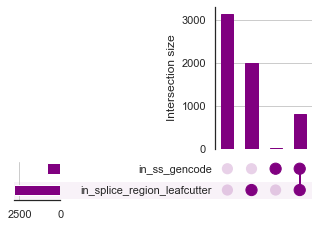

In [68]:

upset_plot(model_output_full,['in_splice_region_leafcutter','in_ss_gencode'], 0.8)



<AxesSubplot:xlabel='LOEUF', ylabel='Proportion'>

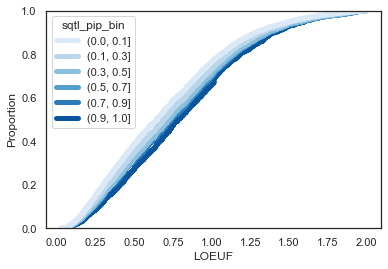

In [421]:
sns.ecdfplot(data=model_output_full, x='LOEUF', hue='sqtl_pip_bin', palette='Blues',
            linewidth=5,
            hue_order=sorted(set(variants_affecting_phenotypes_within_5kb.sqtl_pip_bin)))

In [423]:

model_output_full['SMS_bin']=pd.cut(model_output_full.predicted_prob_being_causal, bins=[0, .1, .3, .6, .8, 0.9, 1])


In [439]:
model_output_full=model_output_full[~model_output_full.predicted_prob_being_causal.isna()]

<AxesSubplot:xlabel='LOEUF', ylabel='Proportion'>

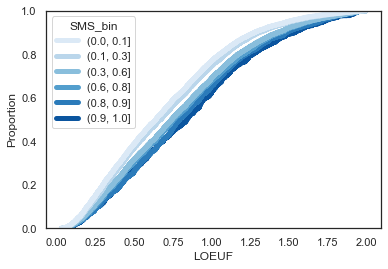

In [441]:
sns.ecdfplot(data=model_output_full, x='LOEUF', hue='SMS_bin', palette='Blues',
            linewidth=5,
            hue_order=sorted(set(model_output_full.SMS_bin)))

<AxesSubplot:xlabel='LOEUF', ylabel='Proportion'>

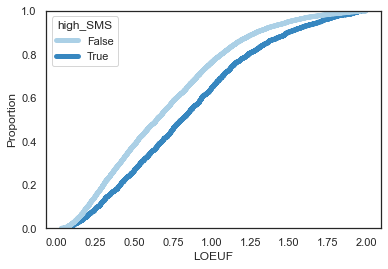

In [452]:
for_plot=model_output_full
for_plot=for_plot.assign(high_SMS=for_plot.predicted_prob_being_causal>=0.8)

sns.ecdfplot(data=model_output_full, x='LOEUF', hue='high_SMS', palette='Blues',
            linewidth=5)

<AxesSubplot:xlabel='LOEUF', ylabel='Proportion'>

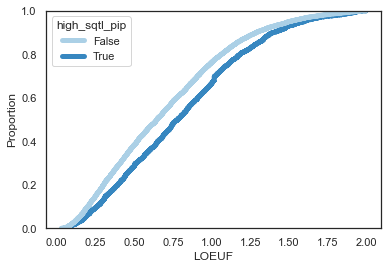

In [461]:
for_plot=model_output_full
for_plot=for_plot.assign(high_sqtl_pip=for_plot.pip>=0.8)

sns.ecdfplot(data=for_plot, x='LOEUF', hue='high_sqtl_pip', palette='Blues',
            linewidth=5)

In [ ]:
sns.ecdfplot(data=model_output_full, x='LOEUF', hue='sqtl_pip_bin', palette='Blues',
            linewidth=5,
            hue_order=sorted(set(variants_affecting_phenotypes_within_5kb.sqtl_pip_bin)))

In [83]:
just_5p_ss_lc = (model_output_full.just_leafcutter_ss) & (model_output_full.in_5p_ss_leafcutter)

just_5p_ss_gencode = (model_output_full.just_gencode_ss) & (model_output_full.in_5p_ss_gencode)


model_output_full=model_output_full.assign(just_5p_ss_lc=just_5p_ss_lc)

model_output_full=model_output_full.assign(just_5p_ss_gencode=just_5p_ss_gencode)


In [91]:
model_output_full[model_output_full.just_5p_ss_lc].max_5p_maxent.median()

8.095746149492186

In [92]:
model_output_full[model_output_full.just_5p_ss_gencode].max_5p_maxent.median()

7.356302617018701

Text(0.5, 1.0, '3 prime ss scores')

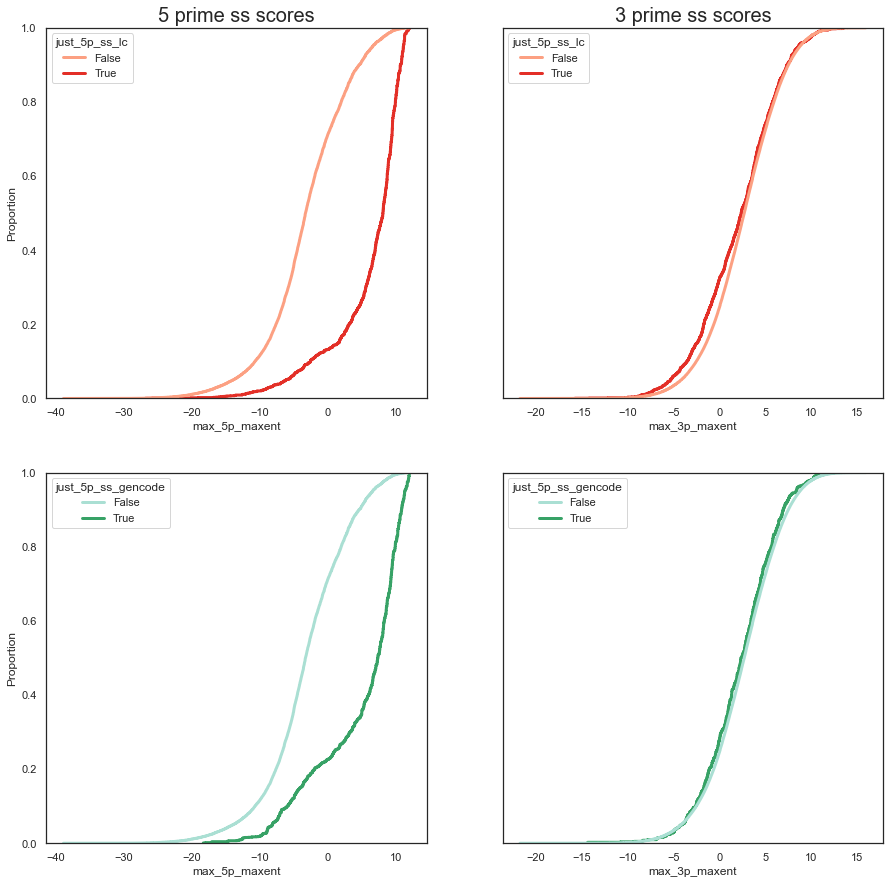

In [84]:

fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True)


ax=sns.ecdfplot(ax=axes[0,0], data=model_output_full, x='max_5p_maxent', hue='just_5p_ss_lc', palette='Reds', linewidth=3)

ax=sns.ecdfplot(ax=axes[1,0],data=model_output_full, x='max_5p_maxent', hue='just_5p_ss_gencode', palette='BuGn', linewidth=3)

axes[0,0].set_title('5 prime ss scores', size=20)

ax=sns.ecdfplot(ax=axes[0,1], data=model_output_full, x='max_3p_maxent', hue='just_5p_ss_lc', palette='Reds', linewidth=3)

ax=sns.ecdfplot(ax=axes[1,1],data=model_output_full, x='max_3p_maxent', hue='just_5p_ss_gencode', palette='BuGn', linewidth=3)

axes[0,1].set_title('3 prime ss scores', size=20)

Sens vs spec

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

Thoughts
--
The best predictors of a variant being causal for a sQTL is being a in a splice site, but importantly, these splice sites are those that is present in the leafcutter phenotypes. 

In general, the categorical variables have lower coef for being causal for a sQTL.

This makes sense though because each individual nt (in the case of dist to ss) or each bit of a maxent score is not very predictive of sQTL PIP. But I would like to see if we can represent the data in a way that is better for sQTL phenotypes

This makes sense though because it is harder to model this data. 


Export data
--